In [1]:
# Import de librerias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import xgboost as xgb
import shap
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBRegressor

c:\Users\david\Desktop\bug-prediction-explanation\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTES
TEST_SIZE = 0.2
ENTRY_TO_EXPLAIN = 1
DATA_FILE = './datasets/dataset.xlsx'
SHEET_NAME = 'method'

# Obtención de los datos

## Infomación

In [3]:
# Importado de los datos al dataframe 
df_original = pd.read_excel(DATA_FILE, sheet_name=SHEET_NAME)
df = df_original
df.head()

,Project,Hash,LongName,CC,CCL,CCO,CI,CLC,CLLC,LDC,...,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Number of Bugs,Buggy
0,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.ClientTimeoutTest.testTim...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,1
1,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
4,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.spi.impl.ClusterListenerT...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


## Tratamiento de datos

In [4]:
# Selección de las features más importantes
df = df[['HDIF', 'HVOL', 'HCPL', 'MISEI', 'MISM', 'MI', 'MIMS', 'NOI', 'HPL', 'HPV', 'NII', 'HNDB', 'NUMPAR', 'TNOS', 'TLOC', 'LOC', 'McCC', 'WarningMinor', 'NOS', 'TCD', 'TLLOC', 'CD', 'Design Rules', 'WarningMajor', 'LLOC', 'CC', 'NL', 'NLE', 'CLC', 'JUnit Rules', 'CLLC', 'CCO', 'LDC', 'TCLOC', 'LLDC', 'Buggy']].copy()
# Eliminación de columnas con un único valor 
df = df[[i for i in df if len(set(df[i]))>1]]

# Eliminación de las filas duplicadas
df = df.drop_duplicates()

# Comprobación de valores null
print('Valores Null: ', df.isnull().sum().sum()) 

# Normalización del Dataframe
df_normalized=(df-df.min())/(df.max()-df.min())


Valores Null:  0


## Separación de features y salida

In [5]:
# Separación de los valores de entrada para el entrenamiento del modelo y los valores de salida
x = df_normalized.drop('Buggy', axis=1)  # valores de entrada
y = df_normalized['Buggy']  # valores de salida

## Oversampling

In [6]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)
print(Counter(y_over))

Counter({1.0: 54498, 0.0: 54498})


# Evaluación del modelo

In [7]:
def evaluacion_modelo(model, x_test, y_test, prediccion): 
	# View the classification report for test data and predictions
	print(classification_report(y_test, prediccion))

	conf_matrix = confusion_matrix(y_test, prediccion)
	conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

	# Confusion matrix usando un heat map
	sns.set(font_scale=1)
	sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Greens)

	# Labels 
	class_names = ['Not Buggy', 'Buggy']
	tick_marks = np.arange(len(class_names))
	tick_marks2 = tick_marks + 0.5
	plt.xticks(tick_marks, class_names, rotation=30)
	plt.yticks(tick_marks2, class_names, rotation=0)
	plt.xlabel('Predicciones')
	plt.ylabel('Valores reales')
	plt.title('Matriz de confusion')
	plt.show()

	# calculate ROC curve
	fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
	roc_auc = auc(fpr, tpr)

	# plot ROC curve
	plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc))
	plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
	plt.xlabel("False Positive Rate")
	plt.ylabel("True Positive Rate")
	plt.title("Receiver Operating Characteristic (ROC) Curve")
	plt.legend()

# Modelo

In [8]:
# Conjuntos de entrenamineto y de test 
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=TEST_SIZE, random_state=42)

### Ajuste de hiperparámetros

In [9]:
rf = RandomForestClassifier(random_state = 42)

search_space = {
    "n_estimators": [600],
    "max_depth": [40],
    "min_samples_split": [1],
    "max_features": [len(x.columns)], 
    "min_samples_leaf" : [1]
}

GS_reduced = GridSearchCV(estimator = rf,
                 param_grid = search_space,
                 scoring = ["r2", "neg_root_mean_squared_error"],
                 refit = "r2",
                 cv = 5,
                 verbose = 4, 
                 n_jobs=-1)

# GS_reduced.fit(important_train_features, y_train)

# print(GS_reduced.best_params_)

N_ESTIMATORS = 600
MAX_DEPTH = 40
MIN_SAMPLES_SPLIT = 1
MAX_FEATURES = len(x.columns)
MIN_SAMPLES_LEAF = 1

## Entrenamiento

              precision    recall  f1-score   support

         0.0       0.81      0.74      0.78     11079
         1.0       0.76      0.83      0.79     10721

    accuracy                           0.78     21800
   macro avg       0.79      0.78      0.78     21800
weighted avg       0.79      0.78      0.78     21800



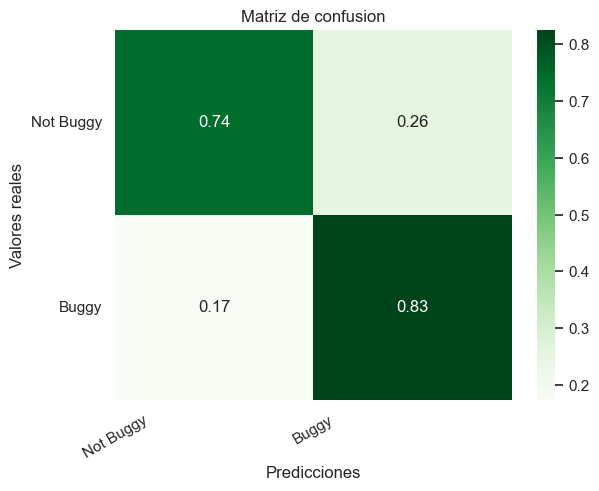

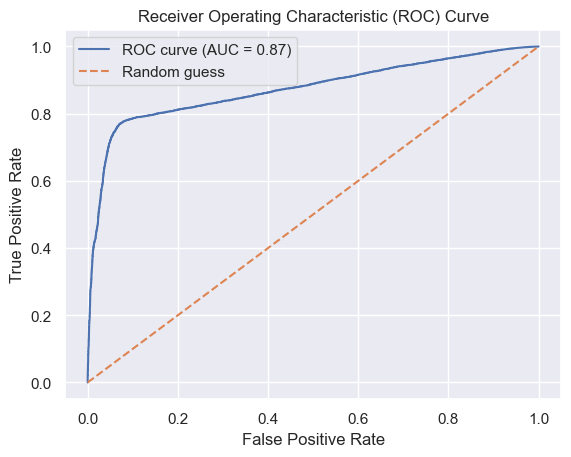

In [10]:
# Modelo rápido para pruebas
# rf = RandomForestClassifier(max_depth= 35, max_features= 20, min_samples_split= 50, n_estimators= 300, n_jobs=-1)
rf = RandomForestClassifier(n_estimators = N_ESTIMATORS, max_depth = MAX_DEPTH,  min_samples_split = MIN_SAMPLES_SPLIT, max_features = MAX_FEATURES, min_samples_leaf = MIN_SAMPLES_LEAF, n_jobs = -1)

# Entrenado del modelo
rf.fit(X_train, y_train)

# Realizar las predicciones 
y_pred = rf.predict(X_test)
evaluacion_modelo(rf, X_test, y_test, y_pred)

# Shap

In [11]:
shap_explainer = shap.TreeExplainer(rf)
shap.initjs()

## Resumen Global

In [12]:
# Plot de resumen global 

# Ejemplo rápido
# shap.summary_plot(shap_explainer.shap_values(X_test.iloc[entry_to_explain-1:entry_to_explain,:]), X_test, plot_type="bar")

# Resumen completo
# shap.summary_plot(shap_explainer.shap_values(X_test), X_test, plot_type="bar")

In [13]:
# Plots para SHAP 
entry_to_explain = 53
print(f'PROBABILIDADES:\n\tNO BUGGY: {rf.predict_proba(X_test)[entry_to_explain, 0]}\n\tBUGGY: {rf.predict_proba(X_test)[entry_to_explain, 1]}')

shap_values = shap_explainer.shap_values(np.array(X_test.iloc[entry_to_explain]))
shap.force_plot(shap_explainer.expected_value[1], shap_values[1], X_test.iloc[entry_to_explain])

PROBABILIDADES:
	NO BUGGY: 0.26020922344974556
	BUGGY: 0.7397907765502545


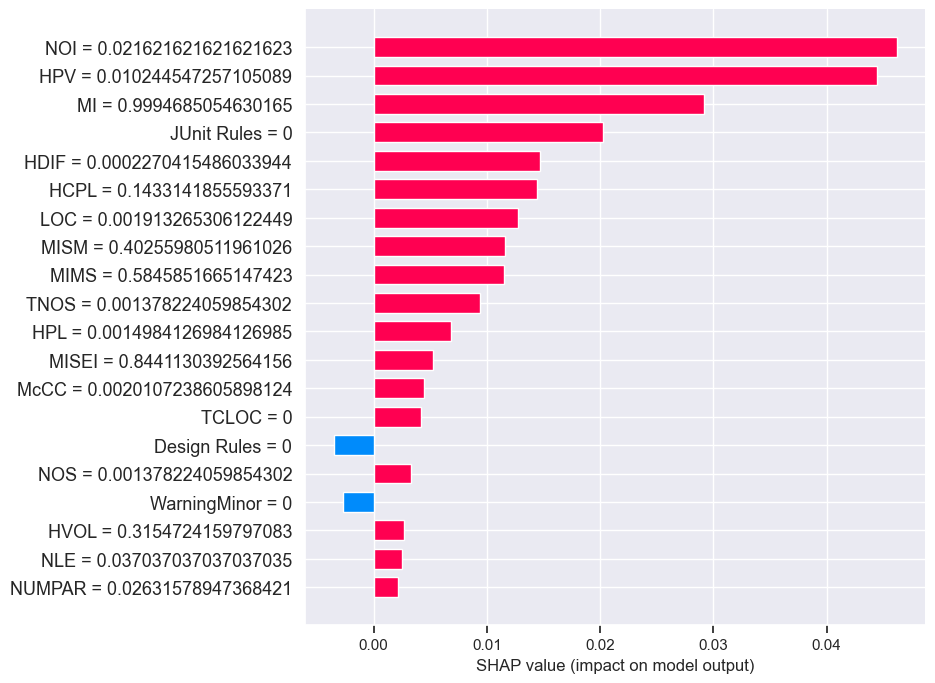

In [14]:
plt.figure(figsize=(8,8))
shap.bar_plot(shap_values[1], features=X_test.iloc[entry_to_explain], max_display=20)

## Funciones shap

In [15]:
def shap_force_plot(data:pd.DataFrame, exp:shap.TreeExplainer, x:int): 
    for i in range(x): 
        sv = exp.shap_values(np.array(data.iloc[i]))
        shap.force_plot(exp.expected_value[1], sv[1], data.iloc[i], matplotlib=True, show=False)
        plt.savefig(f"./img/shap/{i}_force.png", dpi=200, bbox_inches='tight')
        plt.clf()

def shap_bar_plot(data:pd.DataFrame, exp:shap.TreeExplainer, x:int): 
    plt.figure(figsize=(8,8))
    for i in range(x): 
        sv = exp.shap_values(np.array(data.iloc[i]))
        shap.bar_plot(sv[1], features=data.iloc[i], max_display=20, show=False)
        plt.savefig(f"./img/shap/{i}_bar.png", bbox_inches='tight')
        plt.clf()

# shap_force_plot(data=X_new_test, exp=shap_explainer, x=100)
# shap_bar_plot(data=X_new_test, exp=shap_explainer, x=100)

# Lime

In [16]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test, discretize_continuous=True)
exp = lime_explainer.explain_instance(X_test.iloc[entry_to_explain], rf.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


## Funciones Lime

In [17]:
def lime_explain(data:pd.DataFrame, explainer:lime.lime_tabular.LimeTabularExplainer, rf:RandomForestClassifier , x:int): 
    for i in range(x): 
        exp = explainer.explain_instance(data.iloc[i], rf.predict_proba, num_features=10, top_labels=1)
        exp.save_to_file(f"./img/lime/{i}.html")

# lime_explain(data=X_new_test, explainer=lime_explainer,rf = rf, x=100)

# Tree schemas
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

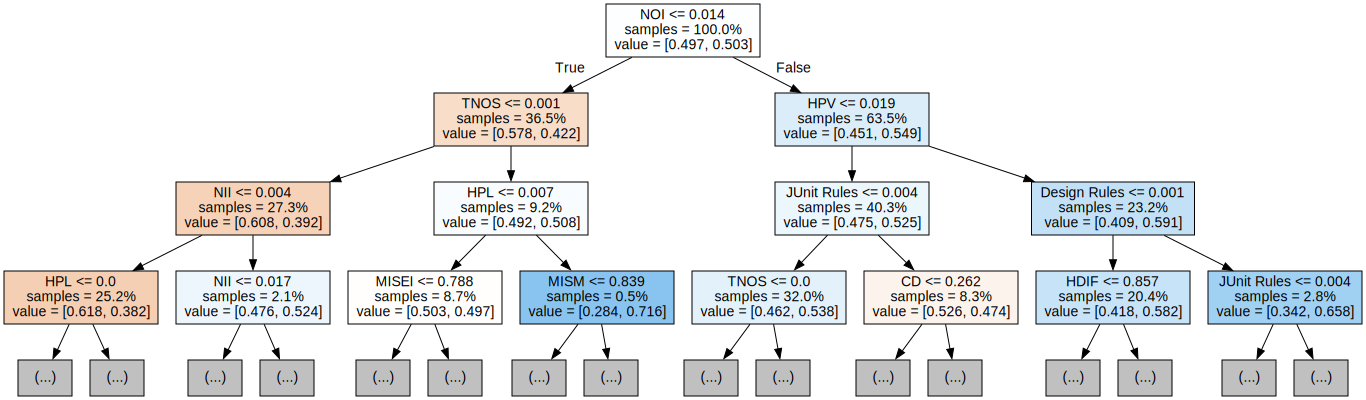

In [44]:
# Ejectura esta parte si está instalado graphviz en el equipo
from sklearn.tree import export_graphviz
import graphviz
for i in [entry_to_explain]:
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    # graph.render(filename=f'g1.dot')
    graph.format = 'png'
    graph.render(filename=f'./img/trees/tree_{i}')
    display(graph)

# XGBoost

In [26]:
xgb_model = XGBRegressor(random_state = 42)

search_space = {
    "n_estimators": [700],
    "max_depth": [50],
    'gamma': [0.5],
    'learning_rate': [0.01],
    'min_child_weight': [5],
    'subsample': [1.0],
    'colsample_bytree': [0.5]
}

GS = GridSearchCV(estimator = xgb_model,
                 param_grid = search_space,
                 scoring = ["r2", "neg_root_mean_squared_error"],
                 refit = "r2",
                 cv = 5,
                 verbose = 4, 
                 n_jobs=-1)

# GS.fit(X_train, y_train)

# print(GS.best_params_)

# {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 50, 'max_features': 72, 'min_samples_split': 3, 'n_estimators': 700}
# {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 50, 'min_child_weight': 5, 'n_estimators': 700, 'subsample': 1.0}
N_ESTIMATORS = 700
MAX_DEPTH = 50
GAMMA = 0.5
LEARNING_RATE = 0.01
MIN_CHILD_WEIGHT = 5
SUBSAMPLE = 1.0
COLSAMPLE_BYTREE = 0.5

In [27]:
# Definición del modelo XGBoost
xgb_model = xgb.XGBClassifier(n_estimators = N_ESTIMATORS, max_depth = MAX_DEPTH, gamma = GAMMA, learning_rate = LEARNING_RATE, min_child_weight = MIN_CHILD_WEIGHT, subsample = SUBSAMPLE, colsample_bytree = COLSAMPLE_BYTREE)

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76     11079
         1.0       0.75      0.79      0.77     10721

    accuracy                           0.76     21800
   macro avg       0.77      0.77      0.76     21800
weighted avg       0.77      0.76      0.76     21800



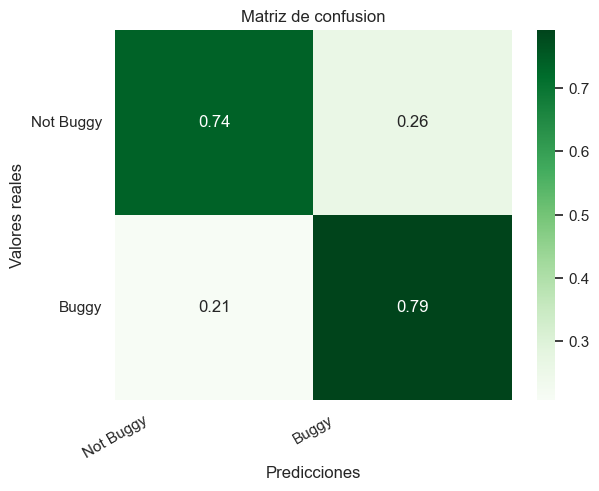

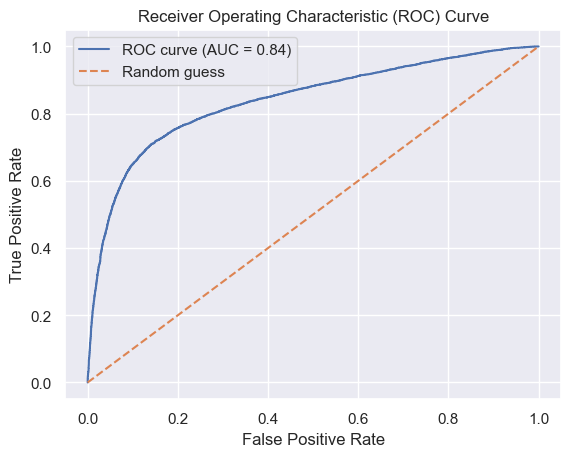

In [28]:
# Comprobamos la precisión en las predicciones del modelo
y_pred = xgb_model.predict(X_test)
evaluacion_modelo(xgb_model, X_test, y_test, y_pred)

# XGBoost with GPU usage

In [29]:
# Definimos el modelo para actuar con el procesado pro GPU
xgb_gpu = xgb.XGBClassifier(tree_method='gpu_hist', n_estimators = N_ESTIMATORS, max_depth = MAX_DEPTH, gamma = GAMMA, learning_rate = LEARNING_RATE, min_child_weight = MIN_CHILD_WEIGHT, subsample = SUBSAMPLE, colsample_bytree = COLSAMPLE_BYTREE, gpu_id = 0)

# Entrenamos el modelo
xgb_gpu.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75     11079
         1.0       0.74      0.78      0.76     10721

    accuracy                           0.76     21800
   macro avg       0.76      0.76      0.76     21800
weighted avg       0.76      0.76      0.76     21800



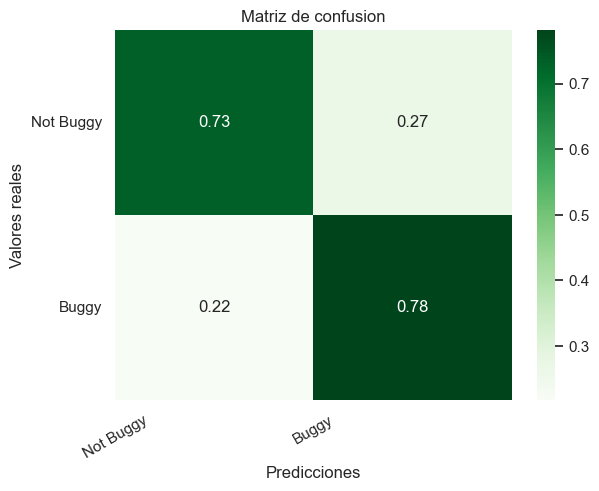

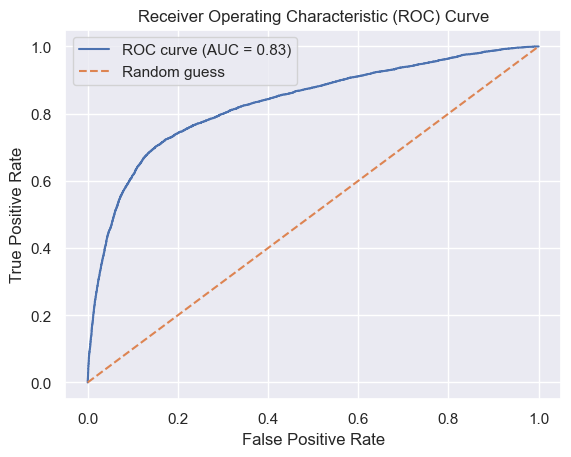

In [30]:
# Comprobamos la precisión en las predicciones del modelo
y_pred = xgb_gpu.predict(X_test)
evaluacion_modelo(xgb_gpu, X_test, y_test, y_pred)